# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import fileinput
import jax.numpy as jnp
import jax
from jax import jacfwd, jacrev

In [2]:
def draw(X, Y, THETA, title):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
        
    plt.title(title)
    plt.show()
    
def read_VERTEX_SE2(filename):
    odometry_edges = []
    for line in fileinput.input(files=filename):
        line_parts = line.split()
        if line_parts[0] == 'VERTEX_SE2':
            edge_no = int(line_parts[1])
            X = float(line_parts[2])
            Y = float(line_parts[3])
            THETA = float(line_parts[4])
            odometry_edges.append([edge_no, X, Y, THETA])
    odometry_edges = jnp.asarray(odometry_edges)       
    return odometry_edges
    
def read_EDGE_SE2(filename):    
    odometry_edges = []
    for line in fileinput.input(files=filename):
        line_parts = line.split()
        if line_parts[0] == 'EDGE_SE2':
            edge_from = int(line_parts[1])
            edge_to = int(line_parts[2])
            dx = float(line_parts[3])
            dy = float(line_parts[4])
            dtheta = float(line_parts[5]) 
            odometry_edges.append([edge_from, edge_to, dx, dy, dtheta])
    odometry_edges = jnp.asarray(odometry_edges)
    return odometry_edges

def write_g2o(filename, data, add_file):
    with open(filename, 'w') as filehandle:
        for nn in range(data.shape[0]):
            filehandle.writelines("VERTEX_SE2 " )
            for i in range(data.shape[1]):
                if i == 0:
                    d = data[nn,i].astype(int)
                    filehandle.writelines("%s " % d)
                else:
                    filehandle.writelines("%s " % data[nn,i])
            filehandle.writelines("\n")
        filehandle.writelines([l for l in open(add_file).readlines() if "VERTEX_SE2" not in l ])
    return

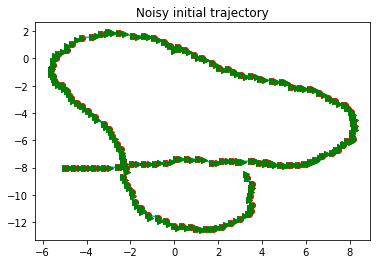

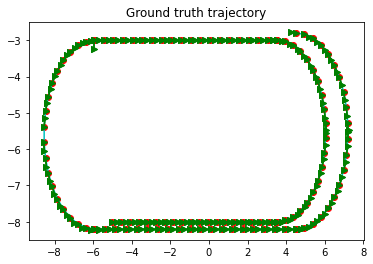

In [3]:
# Obtaining poses
poses = read_VERTEX_SE2("../data/edges.txt")
poses_gnd = read_VERTEX_SE2("../data/gt.txt")

# Obtaining odometry and loop closure constraints
edges = read_EDGE_SE2("../data/edges.txt")
edges_gnd = read_EDGE_SE2("../data/gt.txt")

initialization = []
vertex1 = jnp.array(poses[0,:])
initialization.append(vertex1)

vertex_x = poses[0,1]
vertex_y = poses[0,2]
vertex_theta = poses[0,3]

for nn in range(edges.shape[0]):
    if abs(edges[nn, 0] - edges[nn, 1]) == 1:
        vertex_x = vertex_x + edges[nn, 2]*math.cos(vertex_theta) - edges[nn, 3]*math.sin(vertex_theta)
        vertex_y = vertex_y + edges[nn, 3]*math.cos(vertex_theta) + edges[nn, 2]*math.sin(vertex_theta)
        vertex_theta += edges[nn, 4]
        initialization.append(jnp.array([edges[nn, 1], vertex_x, vertex_y, vertex_theta]))
initialization = jnp.asarray(initialization)
write_g2o("../data/edges-poses.g2o", initialization, "../data/edges.txt")
draw(initialization[:,1], initialization[:,2], initialization[:,3], "Noisy initial trajectory")
draw(poses_gnd[:,1], poses_gnd[:,2], poses_gnd[:,3], "Ground truth trajectory")

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [7]:
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")
    
def draw3(X, Y, THETA, X1, Y1, THETA1, X2, Y2, THETA2, title, title1, title2):
    fig, ax = plt.subplots(1,3)
    ax[0].plot(X, Y, 'ro')
    ax[0].plot(X, Y, 'c-')
    ax[1].plot(X1, Y1, 'ro')
    ax[1].plot(X1, Y1, 'c-')
    ax[2].plot(X2, Y2, 'ro')
    ax[2].plot(X2, Y2, 'c-')
    fig.set_figheight(5)
    fig.set_figwidth(15)
    
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        ax[0].plot([X[i], x2], [Y[i], y2], 'g->')
        ax[0].plot([X[i], x2], [Y[i], y2], 'g->')
        ax[0].set_title(title)
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        ax[1].plot([X1[i], x2], [Y1[i], y2], 'g->')
        ax[1].plot([X1[i], x2], [Y1[i], y2], 'g->')
        ax[1].set_title(title1)
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        ax[2].plot([X2[i], x2], [Y2[i], y2], 'g->')
        ax[2].plot([X2[i], x2], [Y2[i], y2], 'g->')
        ax[2].set_title(title2)
    plt.show() 
def draw3_(X, Y, THETA, X1, Y1, THETA1, X2, Y2, THETA2, it, title, title1, title2):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    ax.plot(X, Y, 'c-')
    
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        ax.plot([X[i], x2], [Y[i], y2], 'g->',  label = title)
        ax.plot([X[i], x2], [Y[i], y2], 'g->')
#         ax.set_legend(title)
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        ax.plot([X1[i], x2], [Y1[i], y2], 'r->',  label = title1)
        ax.plot([X1[i], x2], [Y1[i], y2], 'r->')
#         ax.set_legend(title1)
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        ax.plot([X2[i], x2], [Y2[i], y2], 'b->',  label = title2)
        ax.plot([X2[i], x2], [Y2[i], y2], 'b->')
#         ax.set_legend(title2)
#     path = os.path.join(images_path,str(it)+'.png')
#     plt.savefig(path)
#     plt.legend()
    plt.show() 
    
def t2v(T):
    x = T[0,2]
    y = T[1,2]
    theta = jnp.arctan2(T[1,0], T[0,0])
    return jnp.array([x, y, theta])
def v2t(X):
    T = jnp.zeros((3,3))
    T[0,0] = jnp.cos(X[2])
    T[0,1] = -jnp.sin(X[2])
    T[0,2] = X[0]
    T[1,0] = jnp.sin(X[2])
    T[1,1] = jnp.cos(X[2])
    T[1,2] = X[1]
    T[2,2] = 1
    return T

def calc_residue(flg, vertices1, edges, vertices0):
    ver = vertices1
    r = []
    r_x = []
    r_y = []
    r_theta = []
    if(flg == 1):
        ver = jnp.vstack((vertices0, ver))
        ver = ver.reshape((4,120))
        ver = ver.T
   
    for nn in range(edges.shape[0]):
        edge_from = edges[nn,0]
        edge_to = edges[nn,1]
        dx = edges[nn,2]
        dy = edges[nn,3]
        dtheta = edges[nn,4]
        theta = ver[int(edge_from),3]
        
        res_x = ver[int(edge_from),1] + dx*jnp.cos(theta) - dy*jnp.sin(theta) - ver[int(edge_to),1]  
        res_y = ver[int(edge_from),2] + dy*jnp.cos(theta) + dx*jnp.sin(theta) - ver[int(edge_to),2] 
        res_theta = ver[int(edge_from),3] + dtheta - ver[int(edge_to),3]
        r_x.append(res_x)
        r_y.append(res_y)
        r_theta.append(res_theta)
    r_x.append(ver[0,1]-(-5))  
    r_y.append(ver[0,2]-(-8)) 
    r_theta.append(ver[0,3]-(0)) 
    r_ = [*r_x, *r_y, *r_theta]
    r_ = jnp.asarray(r_)
    return r_   

def calc_J(vertices, edges):
    J_x = []
    J_y = []
    J_theta = []
    for nn in range(edges.shape[0]):
        edge_from = edges[nn,0]
        edge_to = edges[nn,1]
        dx = edges[nn,2]
        dy = edges[nn,3]
        dtheta = edges[nn,4]
        theta = vertices[int(edge_from),3]
        
        Jx = jnp.zeros(360)
        Jx = jax.ops.index_update(Jx, int(edge_from), 1)
        Jx = jax.ops.index_update(Jx, int(edge_to), -1)
        Jx = jax.ops.index_update(Jx, 240 + int(edge_from), -dx*jnp.sin(theta) - dy*jnp.cos(theta))
        Jy = jnp.zeros(360)
        Jy = jax.ops.index_update(Jy, int(edge_from) + 120, 1)
        Jy = jax.ops.index_update(Jy, int(edge_to) + 120, -1)
        Jy = jax.ops.index_update(Jy, 240 + int(edge_from), -dy*jnp.sin(theta) + dx*jnp.cos(theta))
        Jtheta = jnp.zeros(360)
        Jtheta = jax.ops.index_update(Jtheta, int(edge_from) + 240, 1)
        Jtheta = jax.ops.index_update(Jtheta, int(edge_to) + 240, -1)
        J_x.append(Jx)
        J_y.append(Jy)
        J_theta.append(Jtheta)
    Jx = jnp.zeros(360)
    Jx = jax.ops.index_update(Jx, 0, 1)  
    Jy = jnp.zeros(360)
    Jy = jax.ops.index_update(Jy, 120, 1)  
    Jtheta = jnp.zeros(360)
    Jtheta = jax.ops.index_update(Jtheta, 240, 1)  
    J_x.append(Jx)  
    J_y.append(Jy) 
    J_theta.append(Jtheta) 
    J = [*J_x, *J_y, *J_theta]
    J = jnp.asarray(J)
#     print("Size-jacobian: ", J.shape)
    return J    

def info_mat(infoVal):
    indices = jnp.array([0,140,280])
    info_mat = []
    for val in indices:
        for i in range(119):
            row = jnp.zeros(420)
            row = jax.ops.index_update(row, val + i, infoVal[0])
            info_mat.append(row)
        for i in range(119,139):
            row = jnp.zeros(420)
            row = jax.ops.index_update(row, val + i, infoVal[1])
            info_mat.append(row)
        row = jnp.zeros(420)
        row = jax.ops.index_update(row, val + 139, infoVal[2])
        info_mat.append(row)    
    info_mat = jnp.asarray(info_mat)
    return info_mat
def JAXSjacobian(vertices, edges):
    W = jnp.vstack((vertices[:,1], jnp.vstack((vertices[:,2], vertices[:,3]))))
    f = lambda W:calc_residue(1,W,edges,vertices[:,0])
    J = jacrev(f)(W)
    J = J.reshape((420,360))
    return J 

In [9]:
def calculate_J_F_Levenberg_Marquardt(J, r, info_mat, ld):
#     print(J.T@info_mat@J)
#     print(J.T@info_mat.T@r)
    return jnp.linalg.inv(J.T@info_mat@J + ld*jnp.eye(J.shape[1]))@J.T@info_mat.T@r

def calculate_J_F_Levenberg_Marquardt_Modified(J, r, info_mat, ld):
    H = J.T@info_mat@J
    identit = jnp.eye(H.shape[0],H.shape[1])
    for j in range(identit.shape[0]):
            identit = jax.ops.index_update(identit,jax.ops.index[j,j],H[j,j])
    modified = H + ld*identit
#     modified = H + identit

    b = J.T@info_mat@r
    J = jnp.linalg.inv(modified)@b
    return J

def Levenberg_Marquardt(vertices, edges, ld, num_iter, tol, infoVal):
    k = vertices
    ini = vertices
    stop_iter = num_iter 
    scale_factor = 10
    sigma = info_mat(infoVal)
#     print("sigma: ", sigma.shape)
#     print(sigma)
    for i in range(num_iter):
        
#       Finding the residue/cost
        r = calc_residue(0, k, edges, vertices[:,0])
#         print(r)
#         print("r: ", r.shape)
        F = (0.5)*r.T@sigma@r
#         print("F: ", F)
        cost = F
        
#       Calculating the jacobian
        J_r = calc_J(k, edges)
#         print(J_r.shape)
        J_jaxjacob = JAXSjacobian(k, edges)
#         print(J_jaxjacob)
        frobNorm(J_r, J_jaxjacob, "jax jacobian", "analytically calculated jacobian")
#         print(J_r)
#         print("J_r: ", J_r.shape)
        J_F = calculate_J_F_Levenberg_Marquardt_Modified(J_r, r, sigma, ld)
#         print(J_F)
#         print("J_F: ", J_F.shape)
        dk = -J_F
#         print(dk)
#         dk = dk.reshape((3,120))
#       Performing the update  
#         print(k[:, 1:].shape)
#         k[:, 1:] = k[:, 1:] + dk.reshape((3,120)).T
        k = k.at[:, 1:].set(k[:, 1:] + dk.reshape((3,120)).T)
#         print(k)
        r_new = calc_residue(0, k, edges, vertices[:,0])
        cost_new = (0.5)*r_new.T@sigma@r_new
#         print(cost_new)
        if(cost_new < cost):
            print("The error after iteration :%d is %f"%(i+1,cost_new))
            ld = ld/scale_factor  
        else: 
            print("The error after iteration :%d is %f"%(i+1,cost))
            k = k.at[:, 1:].set(k[:, 1:] - dk.reshape((3,120)).T)
            ld = ld*scale_factor
        if((i + 1)%10 == 0):    
            draw3_(k[:,1], k[:,2], k[:,3], ini[:,1], ini[:,2], ini[:,3], poses_gnd[:,1], poses_gnd[:,2], poses_gnd[:,3], i+1, "Initial Noisy trajectory", "Optimized Trajectory", "Ground truth trajectory")    
        if(jnp.linalg.norm(dk) < tol):
            print("dk: ", jnp.linalg.norm(dk))
            stop_iter = i + 1
            break
            
    return k, cost, stop_iter 

In [ ]:
ld  = 0.01
num_iter = 50
tol = 1e-15
infoVal = [25, 250, 500]
optim_poses, cost, stop_iter = Levenberg_Marquardt(initialization, edges, ld, num_iter, tol, infoVal)

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

<!-- <figure> -->
<img src='../data/1.jpeg' alt=drawing width=500 height=600>
<!-- <figure> -->
<img src='../data/2.jpeg' alt=drawing width=500 height=600>
<!-- <figure> -->
<img src='../data/3.jpeg' alt=drawing width=500 height=600>

Observations:
* As the error decreases with the incresing iterations, the plots that are plotted for every 10th iteration improves and resembles more with the ground truth trajectory.  
* Assigning hight weight to loop closure constriants may not be good even though the error is minimised in this case. However, the output path does not resemble the ground truth in the slightest.
* We also observe that except for (5,700,1000), the final optimized trajectories look almost the same.
* From the APE and RPE plots from the next question, we see that the error increases as the information value of the odometry constraint decreases.
* Perhaps the most obvious observation is that of the increase in the error as we increase the weight of the odometry constraint. This is because the odometry is not as reliable as compared to loop closure and anchor points.

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [ ]:
write_g2o("../data/edges-poses_.g2o", optim_poses, "../data/edges.txt")